In [3]:
import scanpy as sc
import seaborn as sns
import pandas as pd
from scipy.stats import median_abs_deviation
import numpy as np
import matplotlib.pyplot as plt
import scrublet as scr
from tqdm.notebook import tqdm

# Hyperparamyters
LIBRARY = "H3"


# Goals

- QC metrics
- Plot cell type annotaions

# Load Adata

In [4]:
ADATA_PATH = f'/home/gdallagl/myworkdir/XDP/data/XDP/disease/240805_SL-EXD_0328_B22FKKYLT4/SI-TT-{LIBRARY}/adata/labelled_adata.h5ad'
adata = sc.read_h5ad(ADATA_PATH)

print(adata)

AnnData object with n_obs × n_vars = 36649 × 38606
    obs: 'x', 'y', 'pct_intronic', 'is_cell', 'Neighborhood_label', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Neighborhood_aggregate_probability', 'Neighborhood_correlation_coefficient', 'Class_label', 'Class_name', 'Class_bootstrapping_probability', 'Class_aggregate_probability', 'Class_correlation_coefficient', 'Subclass_label', 'Subclass_name', 'Subclass_bootstrapping_probability', 'Subclass_aggregate_probability', 'Subclass_correlation_coefficient', 'Group_label', 'Group_name', 'Group_bootstrapping_probability', 'Group_aggregate_probability', 'Group_correlation_coefficient', 'Cluster_label', 'Cluster_name', 'Cluster_alias', 'Cluster_bootstrapping_probability', 'Cluster_aggregate_probability', 'Cluster_correlation_coefficient'
    var: 'feature_types', 'genome', 'gene_symbol'
    obsm: 'spatial'
    layers: 'counts'


# Calculate QC Metrics

In [5]:
# Calculate qc
adata.var["mt"] = adata.var.gene_symbol.str.startswith("MT-") # mitochondrial genes, ATTNETION: the names are in "gene_symbol"
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

In [ ]:
# scrub = scr.Scrublet(adata.X, expected_doublet_rate=0.06)
#     # raw count matrix
#     # for single sample
# doublet_scores, predicted_doublets = scrub.scrub_doublets(
#     min_counts=2,
#     min_cells=3,
#     min_gene_variability_pctl=85,
#     n_prin_comps=30
# )

# adata.obs['doublet_score'] = doublet_scores
# adata.obs['predicted_doublet'] = predicted_doublets

# print(f"\nScrublet results:")
# print(f"  Predicted doublets: {predicted_doublets.sum()} ({100*predicted_doublets.sum()/len(adata):.1f}%)")
# print(f"  Mean doublet score: {doublet_scores.mean():.3f}")

# scrub.plot_histogram()

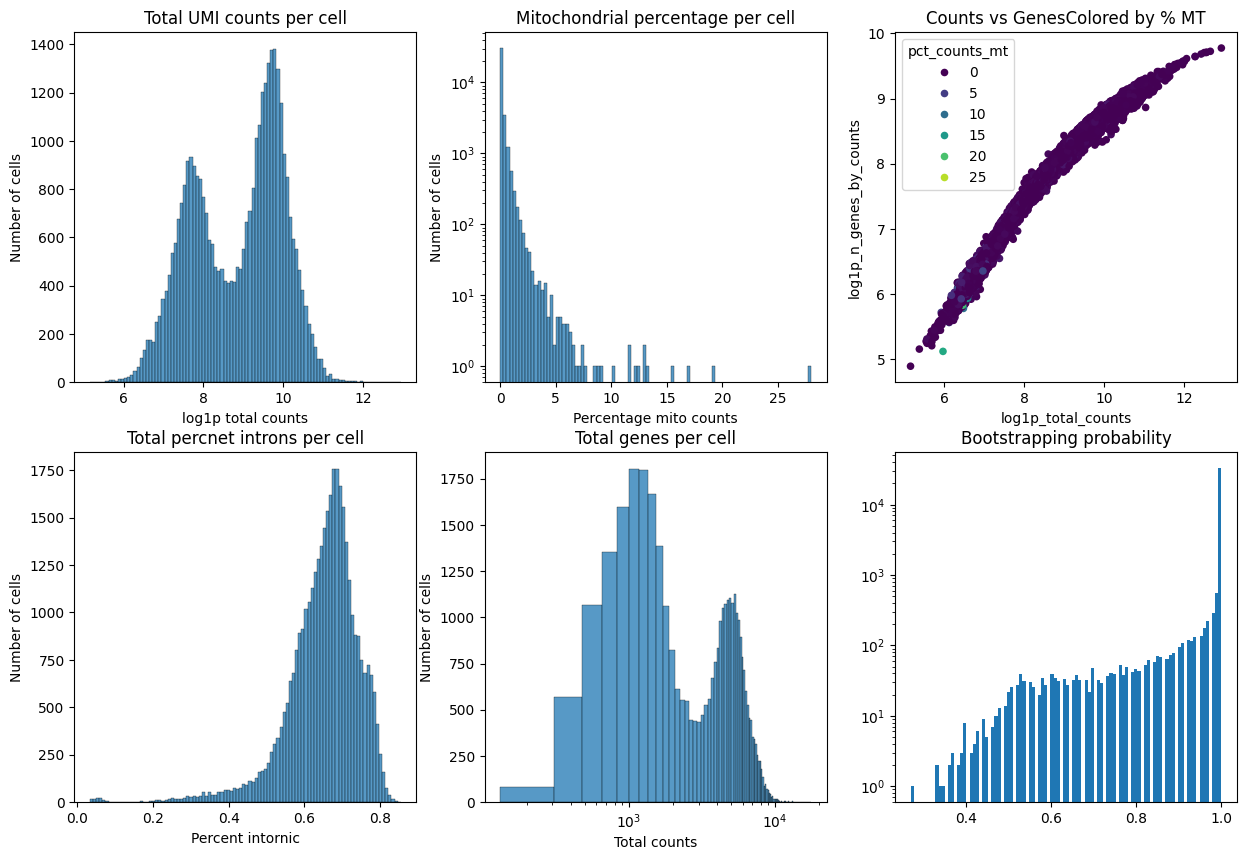

In [6]:
fig, axes = plt.subplots(2,3, figsize=(15, 10))

axes = axes.flatten()

# --- 1. Total UMI counts ---
    # GOOD
        # Single, smooth peak (unimodal distribution)
        # Peak centered around 8-10 on log scale (roughly 3,000-20,000 UMIs)
        # Narrow spread
    # BAD
        # Two peaks (bimodal): Suggests two populations - one could be empty droplets or debris
        # Very wide spread: Indicates high variability in sequencing depth between cells
        # Long left tail: Presence of empty droplets or broken cells
        # peask less than 7
sns.histplot(adata.obs["log1p_total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total UMI counts per cell")
axes[0].set_ylabel("Number of cells")
axes[0].set_xlabel("log1p total counts")

# --- 2. Mitochondrial counts ---
    # GOOD
        # Most cells clustered at lower values
        # Smooth, single-peaked shape
    # BAD
        # Heavy upper tail: Many dying/stressed cells
        # Bimodal (two bumps): Two populations with different health states
sns.histplot(adata.obs["pct_counts_mt"], bins=100, kde=False, ax=axes[1])
axes[1].set_title("Mitochondrial percentage per cell")
axes[1].set_ylabel("Number of cells")
axes[1].set_xlabel("Percentage mito counts")
axes[1].set_yscale("log")

# --- 3. Scatter: counts vs genes, colored by mito ---
    # GOOD
        # Strong positive correlation: Diagonal line from bottom-left to top-right: More total counts = more genes detected
    # BAD
        #  Cells in bottom-left corner (low counts, low genes) --< Empty droplets or debris
sns.scatterplot(
    x=adata.obs["log1p_total_counts"],
    y=adata.obs["log1p_n_genes_by_counts"],
    hue=adata.obs["pct_counts_mt"],
    ax=axes[2],
    s=30,        # point size
    linewidth=0, 
    palette="viridis"
)
axes[2].set_title("Counts vs GenesColored by % MT")

# --- 4. % introns ---
    # GOOD

    # BAD
        # having 2 peaks

sns.histplot(adata.obs["pct_intronic"], bins=100, kde=False, ax=axes[3])
axes[3].set_title("Total percnet introns per cell")
axes[3].set_ylabel("Number of cells")
axes[3].set_xlabel("Percent intornic")

# --- 5. n genes ---
    # GOOD

    # BAD

sns.histplot(adata.obs["n_genes_by_counts"], bins=100, kde=False, ax=axes[4])
axes[4].set_title("Total genes per cell")
axes[4].set_ylabel("Number of cells")
axes[4].set_xlabel("Total counts")
axes[4].set_xscale("log")

# --- 6. mapmycell probs ---
    # GOOD

    # BAD
axes[5].hist(
    adata.obs['Class_bootstrapping_probability'].dropna(),
    bins=100, log=True
)
axes[5].set_title("Bootstrapping probability")

#plt.tight_layout()
plt.show()


# Minimal Filter cells & genes

In [ ]:
# # Filter cells based qc: count per cell, genes per cell, % mt --< using MAD approach 
#     # MAD, sort of std = median of the absloution differcnes form the median
#     # MAD = "How far from typical is this cell?"
#     #Lower threshold = Median - (nmads × MAD)
#     #Upper threshold = Median + (nmads × MAD)
#     # outlier if ANY of these are true --< OR

# def is_outlier(adata, metric: str, nmads: int, direction: str = "both"):
    
#     M = adata.obs[metric]
#     median = np.median(M)
#     mad = median_abs_deviation(M)
    
#     lower_bound = median - nmads * mad
#     upper_bound = median + nmads * mad
    
#     if direction == "both":
#         outlier = (M < lower_bound) | (M > upper_bound)
#     elif direction == "upper":
#         outlier = M > upper_bound
#     elif direction == "lower":
#         outlier = M < lower_bound
#     else:
#         raise ValueError(f"direction must be 'both', 'upper', or 'lower', got '{direction}'")
    
#     return outlier



#'MAD_lower_total_UMI_per_cell': ~is_outlier(adata, "log1p_total_counts", 5, "lower"),


In [7]:
print(f"Starting: {adata.n_obs:,} cells\n")

# Calculate all filters (keep = pass filter)
filters = { # lists of boolen (True == to keep)
    
    'min_UMI': adata.obs["total_counts"] >= 500,
    'min_genes': adata.obs["n_genes_by_counts"] >= 500,
    'mt_threshold': adata.obs["pct_counts_mt"] <= 8,
    'is_cell_dropsift': adata.obs["is_cell"] == True,
    'percent_intronic_threshold': adata.obs["pct_intronic"] >= 0.3,
    'mapmycells_probs_class': (adata.obs['Class_bootstrapping_probability'] >= 0.5), # & (adata.obs['Class_correlation_coefficient'] >= 0.5),
    'spatial_present': ~adata.obs.x.isna(),
}

# Print individual filter stats
n_start = len(adata)
for name, filt in filters.items():
    removed = (~filt).sum()
    print(f"{name:30s}: {removed:6,} removed ({100*removed/len(adata):5.1f}%)")

# Replace adata
cells_to_keep = pd.DataFrame(filters).all(axis=1)  # AND
adata = adata[cells_to_keep].copy()

print(f"Final: {adata.n_obs:,} / {n_start:,} cells retained ({100*adata.n_obs/n_start:.1f}%)")

Starting: 36,649 cells

min_UMI                       :    109 removed (  0.3%)
min_genes                     :    737 removed (  2.0%)
mt_threshold                  :     15 removed (  0.0%)
is_cell_dropsift              :    877 removed (  2.4%)
percent_intronic_threshold    :    329 removed (  0.9%)
mapmycells_probs_class        :     94 removed (  0.3%)
spatial_present               :    609 removed (  1.7%)
Final: 34,440 / 36,649 cells retained (94.0%)


In [ ]:
# Filter genes
print(f"   Genes before filtering: {adata.n_vars}")
sc.pp.filter_genes(adata, min_cells=3)
print(f"   Genes after filtering: {adata.n_vars}")

# Processing Pipeline

In [ ]:
# Normalize & Transform --> X amtrix changes
sc.pp.normalize_total(adata, target_sum=1e4, inplace=True)
sc.pp.log1p(adata)
adata.layers["log1p_norm"] = adata.X.copy()

# HVG
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
sc.pl.highly_variable_genes(adata, show=True)
    # BAD: nif there is not clear seapration

# scale
    # ATTENTION: now X stores nroalised counts --> not used for all stat test alter
sc.pp.scale(adata, max_value=10) #z-score normalization


In [ ]:
# PCA
sc.tl.pca(adata, svd_solver='arpack', n_comps=80) # ATTENTION: # Uses HVGs only (if calculted, even if the adat has all geens)
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=80, show=True)
N_PCS_ELBOW = 30

# neighbours (for umap and leiden)
sc.pp.neighbors(adata, use_rep='X_pca', n_pcs=N_PCS_ELBOW) # from X_pca

# umap
sc.tl.umap(adata) # uese neighbors

# clustering
sc.tl.leiden(adata, resolution=0.1, key_added="leiden_1", flavor="igraph", n_iterations=2) # use neighbors
sc.tl.leiden(adata, resolution=0.5, key_added="leiden_2", flavor="igraph", n_iterations=2)
sc.tl.leiden(adata, resolution=1.0, key_added="leiden_3", flavor="igraph", n_iterations=2)
sc.tl.leiden(adata, resolution=2.0, key_added="leiden_4", flavor="igraph", n_iterations=2)

adata.obs


In [ ]:
# Plor ledein clistering

fig, axes = plt.subplots(4, 2, figsize=(10, 15))

for i, res in enumerate(["leiden_1", "leiden_2", "leiden_3", "leiden_4"]):
    sc.pl.embedding(adata, basis="spatial", color=res, ax=axes[i,0], show=False, legend_loc=None)
    sc.pl.umap(adata, color=res, ax=axes[i,1], show=False, legend_loc=None)

plt.tight_layout()
plt.show()

# Investigate PCs

In [ ]:
# Get loadings for PC1-5
loadings = pd.DataFrame(
    adata.varm['PCs'][:, :5],  # First 5 PCs
    index=adata.var['gene_symbol'],  # Use gene symbols
    columns=[f'PC{i}' for i in range(1, 6)]
)

# Get top 10 genes for each PC
for pc in ['PC1', 'PC2', 'PC3']:
    print(f"\n{pc} - Top Positive Genes:")
    print(loadings[pc].nlargest(10))
    
    print(f"\n{pc} - Top Negative Genes:")
    print(loadings[pc].nsmallest(10))

# Plot
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, pc in enumerate(['PC1', 'PC2', 'PC3', 'PC4', 'PC5']):
    top_genes = pd.concat([
        loadings[pc].nlargest(10),
        loadings[pc].nsmallest(10)
    ]).sort_values()
    
    top_genes.plot(kind='barh', ax=axes[i], color='steelblue')
    axes[i].set_title(f'{pc} Top Genes')
    axes[i].set_xlabel('Loading')

plt.tight_layout()
plt.show()

**PC1: Oligodendrocytes ↔ Neurons**

Positive (Neuronal):
  CELF2, ARHGAP26, KCNMA1, SLC8A1, NEBL
  → Neuronal genes (ion channels, synaptic)

Negative (Oligodendrocyte):
  PLP1 (-0.058) ← MAJOR myelin gene!
  APOD, LAMA2
  → Oligodendrocyte/myelin genes

**PC2: Immune Cells ↔ Neurons**

Positive (Immune):
  PTPRC (CD45), CSF1R, DOCK8, HCLS1
  → Microglia/immune markers

Negative (Neuronal):
  NRXN1, NRCAM, GABRB1, CNTN1
  → Neuronal adhesion/synaptic genes

**PC3: Excitatory Neurons ↔ Astrocytes**

Positive (Excitatory Neurons):
  GRIN2B, SYT1, MYT1L, RIMS2, SYN2
  → Glutamatergic neuronal genes

Negative (Astrocytes):
  GFAP, AQP4, ATP1A2, SPARCL1
  → Canonical astrocyte markers

In [ ]:
# PCs are capturing real biological variation
adata.obs['PC1'] = adata.obsm['X_pca'][:, 0] # Oligos Vs rest
adata.obs['PC2'] = adata.obsm['X_pca'][:, 1] # Immune Vs rest
adata.obs['PC3'] = adata.obsm['X_pca'][:, 2] # Excitatory neurons vs astrocytes

sc.pl.umap(adata, color=['PC1', 'PC2', 'PC3'], cmap='RdBu_r')

In [ ]:
# Correlation of PC1 with QC metrics
import scipy.stats as stats

qc_metrics = ['total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'pct_intronic']

print("PC1 Correlation with QC Metrics:")
for metric in qc_metrics:
    corr, pval = stats.pearsonr(adata.obsm['X_pca'][:, 0], adata.obs[metric])
    print(f"  {metric:25s}: r={corr:6.3f}, p={pval:.2e}")

# If ANY correlation > 0.5 → PC1 is capturing technical noise! --> PC1 has moderate correlation with sequencing depth:

# 2. Visualize
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, metric in enumerate(qc_metrics):
    axes[i].scatter(
        adata.obsm['X_pca'][:, 0], 
        adata.obs[metric],
        s=1, alpha=0.3
    )
    axes[i].set_xlabel('PC1')
    axes[i].set_ylabel(metric)
    axes[i].set_title(f'PC1 vs {metric}')

plt.tight_layout()
plt.show()

# # 3. Color UMAP by QC metrics to compare with PC1
# sc.pl.umap(adata, color=['PC1', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 
#            cmap='viridis', ncols=4)
# # If they look similar → PC1 = technical artifact

# Save Minimal filtered Adata

In [ ]:
adata.write(f'/home/gdallagl/myworkdir/XDP/data/XDP/disease/240805_SL-EXD_0328_B22FKKYLT4/SI-TT-{LIBRARY}/adata/minimal_filtered_adata.h5ad')
del(adata)

In [ ]:
adata = sc.read_h5ad(f'/home/gdallagl/myworkdir/XDP/data/XDP/disease/240805_SL-EXD_0328_B22FKKYLT4/SI-TT-{LIBRARY}/adata/minimal_filtered_adata.h5ad')

# QC metrics on umap

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for i, res in enumerate(["log1p_total_counts", "log1p_n_genes_by_counts", "pct_intronic", "pct_counts_mt", "Class_bootstrapping_probability"]):
    sc.pl.embedding(adata, basis="spatial", color=res, ax=axes[i,0], show=False, legend_loc=None)
    sc.pl.umap(adata, color=res, ax=axes[i,1], show=False, legend_loc=None)

plt.tight_layout()
plt.show()

# Metrics by Cluster

In [ ]:
CLUSTER_LEVEL = "leiden_4"
ANNOTATION_LEVEL = "Subclass_name"

## QC metrics by clusters

In [ ]:
metrics = [
    "total_counts",
    "n_genes_by_counts",
    "pct_intronic",
    "pct_counts_mt",
    "Class_bootstrapping_probability",
]

# compute mean of each metric for each cluster
df_means = (
    adata.obs
    .groupby(CLUSTER_LEVEL, observed=False)[metrics]
    .mean()
    .reset_index()
)


df_means = df_means.set_index(CLUSTER_LEVEL)
# display(df_means)

# # flag clusters where ANY metric is > 2 SD above mean
# # thresholds
# putative_bad_clusters_by_qc = df_means[(
#     (df_means["total_counts"] > 30000) |
#     (df_means["n_genes_by_counts"] > 7000) |
#     (df_means["pct_intronic"] < 0.4) | 
#     (df_means["pct_intronic"] > 0.8) |
#     (df_means["pct_counts_mt"] > 0.4) |
#     (df_means["Class_bootstrapping_probability"] < 0.7)
# )].index.tolist()
# print(putative_bad_clusters_by_qc)


# Plot
fig, axes = plt.subplots(2, 3, figsize=(20, 8))
axes = axes.flatten()

for ax, col in zip(axes, metrics):
    df_means[col].plot(kind="bar", ax=ax)
    ax.set_title(col)
    ax.set_ylabel("mean")
    ax.tick_params(axis="x")#, rotation=45)

# hide any unused axes
for ax in axes[len(metrics):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


# sc.pl.embedding(adata, basis="X_umap", color="leiden_4", legend_loc="on data")


## UMI counts distribution by cluster

In [ ]:
# Get unique clusters
clusters = adata.obs[CLUSTER_LEVEL].unique()

n_clusters = len(clusters)
ncols = 5
nrows = int(np.ceil(n_clusters / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(20, 3*nrows))
axes = axes.flatten()

for idx, cluster in enumerate(clusters):
    ax = axes[idx]
    
    # Get data for this cluster
    cluster_data = adata.obs[adata.obs[CLUSTER_LEVEL] == cluster]['total_counts']
    
    # Plot histogram
    ax.hist(cluster_data, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    ax.set_title(f'Cluster {cluster}', fontweight='bold')
    ax.set_xlabel('Total Counts')
    ax.set_ylabel('# Cells')
    
    # Add mean line
    mean_val = cluster_data.mean()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {mean_val:.0f}')
    
    # Same x-axis for all
    #ax.set_xlim(global_min, global_max)
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

# Hide unused subplots
for idx in range(n_clusters, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Total Counts Distribution per Cluster', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Cell Type distribution by cluster

In [ ]:
# Calculate cell type composition for each cluster
cluster_composition = pd.crosstab(
    adata.obs[CLUSTER_LEVEL], 
    adata.obs[ANNOTATION_LEVEL]
)

# Convert to percentages
cluster_composition_pct = cluster_composition.div(cluster_composition.sum(axis=1), axis=0) * 100

# Plot 1: Stacked bar chart (percentage)
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

cluster_composition_pct.plot(
    kind='bar', 
    stacked=True, 
    ax=axes[0],
    colormap='tab20'
)
axes[0].set_title(f'Cell Type Composition per {CLUSTER_LEVEL} (Percentage)')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Percentage (%)')
axes[0].legend(title=ANNOTATION_LEVEL, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# Plot 2: Stacked bar chart (absolute counts)
cluster_composition.plot(
    kind='bar', 
    stacked=True, 
    ax=axes[1],
    colormap='tab20'
)
axes[1].set_title(f'Cell Type Composition per {CLUSTER_LEVEL} (Counts)')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Number of cells')
axes[1].legend(title=ANNOTATION_LEVEL, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print summary: dominant cell type per cluster
print("\nDominant cell type per cluster:")
for cluster in cluster_composition_pct.index:
    dominant_type = cluster_composition_pct.loc[cluster].idxmax()
    percentage = cluster_composition_pct.loc[cluster, dominant_type]
    count = cluster_composition.loc[cluster, dominant_type]
    total = cluster_composition.loc[cluster].sum()
    print(f"  Cluster {cluster}: {dominant_type} ({count}/{total} cells, {percentage:.1f}%)")

## Cell Type distribution on Umap/spatial

In [ ]:
subclasses = adata.obs[ANNOTATION_LEVEL].value_counts().index.to_list()
n_subclasses = len(subclasses)

# Calculate rows (ceiling division)
n_rows = int(np.ceil(n_subclasses / 2))
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
axes = axes.flatten()  # Flatten to 1D for easy indexing

for i, s in enumerate(subclasses):
    # Create highlight column
    adata.obs["temp_highlight"] = adata.obs[ANNOTATION_LEVEL].apply(
        lambda x: s if x == s else 'Other'
    )
    
    # Spatial plot (left side: columns 0, 2, 4, ...)
    sc.pl.embedding(
        adata, 
        basis="spatial", 
        color="temp_highlight", 
        palette={'Other': 'lightgray', s: 'red'}, 
        ax=axes[i*2], 
        show=False, 
        legend_loc=None, 
        size=10,
        title=f"{s} (spatial)"
    )
    
    # UMAP plot (right side: columns 1, 3, 5, ...)
    sc.pl.embedding(
        adata, 
        basis="X_umap", 
        color="temp_highlight", 
        palette={'Other': 'lightgray', s: 'red'}, 
        ax=axes[i*2 + 1], 
        show=False, 
        legend_loc=None,
        title=f"{s} (UMAP)"
    )

# Hide unused subplots
for j in range(i*2 + 2, len(axes)):
    axes[j].axis('off')

# Clean up temp column
adata.obs.drop('temp_highlight', axis=1, inplace=True)

plt.tight_layout()
plt.show()

## Overall cell type distribution

In [ ]:
for ann in ["Class_name", "Group_name"]:
    vc = adata.obs[ann].value_counts().sort_values(ascending=False)
    vp = vc / vc.sum() * 100  # percentages

    fig, axes = plt.subplots(1, 3, figsize=(25, 6))

    # log scale
    vc.plot(kind="bar", logy=True, ax=axes[0])
    axes[0].set_title(f"{ann} counts (log y)")
    axes[0].set_xlabel("")
    axes[0].set_ylabel("Counts")

    # linear scale
    vc.plot(kind="bar", logy=False, ax=axes[1])
    axes[1].set_title(f"{ann} counts (linear y)")
    axes[1].set_xlabel("")
    axes[1].set_ylabel("Counts")

    # percentages
    vp.plot(kind="bar", ax=axes[2])
    axes[2].set_title(f"{ann} percentages")
    axes[2].set_xlabel("")
    axes[2].set_ylabel("Percentage (%)")

    # rotate all x-labels
    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    plt.tight_layout()
    plt.show()


# Remove Doublets clusters

excluding cell clusters that co-express marker genes of distinct cell types (not UMI based approach).

Problem: Homotypic doublets (formed by transcriptionally similar cells) cannot be detected this way

Check if the doublet cluster is positioned between its "parent" clusters in UMAP space


In [ ]:
markers = {
    # Non-neuronal cells
    'Astrocyte': ['GFAP', 'AQP4', 'GINS3'],
    
    'Ependymal': ['ZBBX'],
    
    'Endothelial': ['DCN', 'FLT1'],
    
    'Lymphocyte': ['SKAP1', 'THEMIS'],
    
    'Microglia': ['CX3CR1', 'P2RY12', 'C1QA', 'C1QB', 'C1QC'],
    
    'Macrophage': ['CD163', 'CD200R1'],
    
    'Oligodendrocyte': ['MOBP', 'MBP', 'PLP1'],# 'SHROOM4', 'TF'],
    
    'OPC': ['VCAN', 'PDGFRA'],
    
    # Neurons - using ONLY subtype-specific markers (no RBFOX3/SYT1 overlap)
    'Neuron_inhibitory': ['GAD1', 'GAD2', 'SLC32A1'],
    
    'Neuron_excitatory': ['SLC17A6', 'SLC17A7', 'SLC17A8'],
    
    'Neuron_dopaminergic': ['SLC6A3', 'TH'],
    
    'Neuron_cholinergic': ['CHAT'],
    
    'Neuron_serotonergic': ['SLC6A4'],
}

mapping_genes_name_dict = adata.var[["gene_symbol"]].to_dict()["gene_symbol"].copy()
symbol_to_varid = {v.upper(): k for k, v in mapping_genes_name_dict.items() if isinstance(v, str)}
translated_markers = {
    celltype: [symbol_to_varid.get(gene.upper(), None) for gene in genes]
    for celltype, genes in markers.items()
}

display(translated_markers)


## Plot single markers expression

In [ ]:
gene_to_plot = set()
for key, item in markers.items():
    gene_to_plot.update(set(item))
    
sc.pl.umap(adata, color=gene_to_plot, cmap='viridis', ncols=4, gene_symbols="gene_symbol")#, vmin=-1, vmax=1)


## Putative Doublets by gene Markers

Find gene makers (DEGs) for each cluster and see if they are ibtersection with makrher genes of a specific cell type.

If they overlap wiht more than 2 cell types they coudl be doublets.

In [ ]:
# Find marker genes for each cluster (equivalent to FindAllMarkers)
    # need log normlsied data --< NPY scaled
    # DEG: cluster Vs rest
sc.tl.rank_genes_groups(
    adata, 
    groupby=CLUSTER_LEVEL, 
    method='wilcoxon', 
    reference="rest", 
    corr_method="benjamini-hochberg",
    use_raw=False, 
    layer="log1p_norm", #ATTNETION: NOT scaled data in X
    pts = True, # ATTENTION; % cells expressing gene IN and OUT cluster 
)

In [ ]:
# Get top genes as DataFrame
top_n = 300
doublet_clusters_markers = {}

for cluster in tqdm(adata.obs['leiden_4'].cat.categories):

    # Get top genes for this cluster
    df = sc.get.rank_genes_groups_df(adata, group=cluster) # sorted by score

    df = df[
        (df.pvals_adj < 0.05) &
        (df.logfoldchanges > 1) &
        (df.scores > 0) &
        (df['pct_nz_group'] > 0.25) &  # only test genes that are detected in a minimum fraction  IN cluster
        (df['pct_nz_reference'] < 0.50) & # only test genes NOT expressed outside
        ((df['pct_nz_group'] - df['pct_nz_reference']) > 0.10) # Gene must be >10% more frequent in cluster than outside  
    ] 


    #display(df)
    top_genes = set(df.head(top_n)['names'].tolist())
    #print(top_genes)

    # check if these top genes overlpa wiht one of the gene list of a specific cell type
    cell_types_found = {}
    for cell_type, cell_type_markers in translated_markers.items(): # ATTENTION: gene name
        overlap = top_genes & set(cell_type_markers)
        if len(overlap) != 0:
            cell_types_found[cell_type] = list(overlap)

    if len(cell_types_found.keys()) >= 2:
        doublet_clusters_markers[cluster] = list(cell_types_found.keys())


display(doublet_clusters_markers)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, g in zip(axes, [list(doublet_clusters_markers.keys()), ["21","23", "38","40"]]):
    sc.pl.embedding(adata, basis="X_umap", color="leiden_4", legend_loc="on data",
                    groups=g, ax=ax, show=False, return_fig=False)
plt.tight_layout(); plt.show()




## Putative Doublets by Module score and Entropy

FOr each cell tyope marker genes lists, calculate the relative module socre (for each cell).

Calculate mean module score for each cluster for each module.

Claulte Entropy of these menas per cluster.

CLusters wiht high entropy (mix of modules) are doublets.

In [ ]:
# DOUBLETS USING MODULE SCORE

for cell_type, genes in tqdm(translated_markers.items()):
    # Only use genes that exist in your data
    #genes_available = [g for g in genes if g in adata.var.gene_symbol.to_list()]
    
    if len(genes) > 0:
        #print(f"  {cell_type}: {len(genes)} markers")
        sc.tl.score_genes(adata, genes, score_name=f'{cell_type}_score', use_raw=False, layer="log1p_norm") # normalised scores (not scaled)
    else:
        print(f"  ⚠ {cell_type}: No markers found!")

# plot umaps
score_cols = [f'{ct}_score' for ct in markers.keys() if f'{ct}_score' in adata.obs]
sc.pl.umap(adata, color=score_cols, cmap='viridis', ncols=3, vmin=-1, vmax=1)


In [ ]:
# plot moduels per cluster
# Get mean scores per cluster
cluster_scores = adata.obs.groupby(CLUSTER_LEVEL, observed=False)[score_cols].mean()

# Clean column names
cluster_scores.columns = [c.replace('_score', '') for c in cluster_scores.columns]

# Simple barplot - one per cluster
n_clusters = len(cluster_scores)
ncols = 6
nrows = int(np.ceil(n_clusters / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
axes = axes.flatten() if n_clusters > 1 else [axes]

for idx, (cluster, row) in enumerate(cluster_scores.iterrows()):
    ax = axes[idx]
    
    # Sort values for easier reading
    sorted_data = row.sort_values(ascending=True)
    
    # Plot
    ax.barh(range(len(sorted_data)), sorted_data.values, color='steelblue')
    ax.set_yticks(range(len(sorted_data)))
    ax.set_yticklabels(sorted_data.index, fontsize=8)
    ax.set_xlabel('Mean Module Score', fontsize=9)
    ax.set_title(f'Cluster {cluster}', fontweight='bold')
    ax.axvline(0, color='black', linestyle='--', linewidth=0.8)
    ax.grid(axis='x', alpha=0.3)
    ax.set_xlim((-0.2, 1))
    ax.axvline(0.4, linestyle='--', linewidth=1, color="red")

# Hide empty subplots
for idx in range(n_clusters, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import entropy

# Calculate entropy for each cluster (higher = more mixed)
cluster_scores_entropy = cluster_scores.copy()
cluster_scores_entropy['entropy'] = cluster_scores.apply(
    lambda x: entropy(x[x > 0] / x[x > 0].sum()) if (x > 0).sum() > 1 else 0,  # clauclte onyl for vlaues bogger than 0
    axis=1
)

# Flag top 25% as potential doublets
threshold = cluster_scores_entropy['entropy'].quantile(0.75)
high_entropy_clusters = cluster_scores_entropy[cluster_scores_entropy['entropy'] > threshold]

# Plot
cluster_scores_entropy['entropy'].sort_values(ascending=False).plot(
    kind='bar', figsize=(12, 5), color='steelblue', title='Cluster Entropy'
)
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.2f}')
plt.ylabel('Entropy (higher = doublet)')
plt.legend()
plt.tight_layout()
plt.show()

# Create doublet dictionary: cluster -> cell types with high scores
doublet_clusters_entropy = {}
for cluster in high_entropy_clusters.index:
    scores = cluster_scores_entropy.loc[cluster].drop('entropy')
    # Get cell types with scores > 0.3
    threshold = scores.quantile(0.75) 
    active_types = scores[scores > threshold].sort_values(ascending=False)
    if len(active_types) >= 2:
        doublet_clusters_entropy[cluster] = active_types.index.tolist()

# Display results
print("Entropy-based doublet clusters:")
display(doublet_clusters_entropy)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, clusters in zip(axes, [list(doublet_clusters_entropy.keys()), ["23", "27", "35","40"]]):
    sc.pl.embedding(adata, basis="X_umap", color="leiden_4", legend_loc="on data",
                    groups=clusters, ax=ax, show=False)
plt.tight_layout()
plt.show()

## Plot Oligos Marker

Difficult to distinguish evolving Oligos from doubelts

In [ ]:
# Check if they're differentiating OPCs (real) or doublets (artifact)
#(Oligo + OPC)
# REAL BIOLOGY (good) ✓
# OPC differentiating into Oligodendrocyte
# → Transition state, should KEEP!
#  BCAS1 expression (differentiation marker) --> BCAS1 high → Real differentiating cells → KEEP ✓
sc.pl.umap(adata, color=['Subclass_name', 
                         'BCAS1',  # differentiationg
                         'VCAN', # OPC
                         'MBP', 'PLP1', 'MOBP' # Mature Oligo
                         ], gene_symbols="gene_symbol", ncols=3, legend_loc="on data")

## Call Doublets by overlapping methods

In [ ]:
common_keys = sorted(doublet_clusters_entropy.keys() & doublet_clusters_markers.keys())

final_dt = {
    k: [doublet_clusters_entropy[k], doublet_clusters_markers[k]]
    for k in common_keys
}

display(final_dt)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, clusters in zip(axes, [list(final_dt.keys()), ["23", "38","40"]]):
    sc.pl.embedding(adata, basis="X_umap", color="leiden_4", legend_loc="on data",
                    groups=clusters, ax=ax, show=False)
plt.tight_layout()
plt.show()

## Filter

In [ ]:
DOUBLET_CLUSTERS = ["23", "38","40"]
print(adata)
adata = adata[~adata.obs[CLUSTER_LEVEL].isin(DOUBLET_CLUSTERS)]
print(adata)

adata.write(f'/home/gdallagl/myworkdir/XDP/data/XDP/disease/240805_SL-EXD_0328_B22FKKYLT4/SI-TT-{LIBRARY}/adata/doublets_filtered_adata.h5ad')

# Reprocess Clean Data

In [ ]:
# ATTENTION: bring bacj count
adata.X = adata.layers["counts"]

# Normalize & Transform --> X amtrix changes
sc.pp.normalize_total(adata, target_sum=1e4, inplace=True)
sc.pp.log1p(adata)
adata.layers["log1p_norm"] = adata.X.copy()

# HVG
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
sc.pl.highly_variable_genes(adata, show=True)
    # BAD: nif there is not clear seapration

# scale
    # ATTENTION: now X stores nroalised counts --> not used for all stat test alter
sc.pp.scale(adata, max_value=10) #z-score normalization

# PCA
sc.tl.pca(adata, svd_solver='arpack', n_comps=80) # ATTENTION: # Uses HVGs only (if calculted, even if the adat has all geens)
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=80, show=True)
N_PCS_ELBOW = 30

# neighbours (for umap and leiden)
sc.pp.neighbors(adata, use_rep='X_pca', n_pcs=N_PCS_ELBOW) # from X_pca

# umap
sc.tl.umap(adata) # uese neighbors

# clustering
sc.tl.leiden(adata, resolution=0.1, key_added="leiden_1", flavor="igraph", n_iterations=2) # use neighbors
sc.tl.leiden(adata, resolution=0.5, key_added="leiden_2", flavor="igraph", n_iterations=2)
sc.tl.leiden(adata, resolution=1.0, key_added="leiden_3", flavor="igraph", n_iterations=2)
sc.tl.leiden(adata, resolution=2.0, key_added="leiden_4", flavor="igraph", n_iterations=2)

adata.write(f'/home/gdallagl/myworkdir/XDP/data/XDP/disease/240805_SL-EXD_0328_B22FKKYLT4/SI-TT-{LIBRARY}/adata/reprocessed_filtered_adata.h5ad')
del(adata)


In [ ]:
adata = sc.read_h5ad(f'/home/gdallagl/myworkdir/XDP/data/XDP/disease/240805_SL-EXD_0328_B22FKKYLT4/SI-TT-{LIBRARY}/adata/reprocessed_filtered_adata.h5ad')

# Plots

### MapMyCells Labels

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 14))

for i, res in enumerate(["leiden_4", "Group_name"]):
    sc.pl.embedding(adata, basis="spatial", color=res, ax=axes[i,0], show=False, legend_loc=None)
    sc.pl.umap(adata, color=res, ax=axes[i,1], show=False, legend_fontsize=6, size=8)# legend_loc="lower center")

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(20, 15))

for i, res in enumerate(["Neighborhood_name", "Class_name", "Subclass_name", "Group_name"]):
    sc.pl.embedding(adata, basis="spatial", color=res, ax=axes[i,0], show=False, legend_loc=None)
    sc.pl.umap(adata, color=res, ax=axes[i,1], show=False, legend_fontsize=6)# legend_loc="lower center")

plt.tight_layout()
plt.show()

In [ ]:
for ann in ["Class_name", "Group_name"]:
    vc = adata.obs[ann].value_counts().sort_values(ascending=False)
    vp = vc / vc.sum() * 100  # percentages

    fig, axes = plt.subplots(1, 3, figsize=(25, 6))

    # log scale
    vc.plot(kind="bar", logy=True, ax=axes[0])
    axes[0].set_title(f"{ann} counts (log y)")
    axes[0].set_xlabel("")
    axes[0].set_ylabel("Counts")

    # linear scale
    vc.plot(kind="bar", logy=False, ax=axes[1])
    axes[1].set_title(f"{ann} counts (linear y)")
    axes[1].set_xlabel("")
    axes[1].set_ylabel("Counts")

    # percentages
    vp.plot(kind="bar", ax=axes[2])
    axes[2].set_title(f"{ann} percentages")
    axes[2].set_xlabel("")
    axes[2].set_ylabel("Percentage (%)")

    # rotate all x-labels
    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    plt.tight_layout()
    plt.show()


In [ ]:
subclasses = adata.obs[ANNOTATION_LEVEL].value_counts().index.to_list()
n_subclasses = len(subclasses)

# Calculate rows (ceiling division)
n_rows = int(np.ceil(n_subclasses / 2))
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
axes = axes.flatten()  # Flatten to 1D for easy indexing

for i, s in enumerate(subclasses):
    # Create highlight column
    adata.obs["temp_highlight"] = adata.obs[ANNOTATION_LEVEL].apply(
        lambda x: s if x == s else 'Other'
    )
    
    # Spatial plot (left side: columns 0, 2, 4, ...)
    sc.pl.embedding(
        adata, 
        basis="spatial", 
        color="temp_highlight", 
        palette={'Other': 'lightgray', s: 'red'}, 
        ax=axes[i*2], 
        show=False, 
        legend_loc=None, 
        size=10,
        title=f"{s} (spatial)"
    )
    
    # UMAP plot (right side: columns 1, 3, 5, ...)
    sc.pl.embedding(
        adata, 
        basis="X_umap", 
        color="temp_highlight", 
        palette={'Other': 'lightgray', s: 'red'}, 
        ax=axes[i*2 + 1], 
        show=False, 
        legend_loc=None,
        title=f"{s} (UMAP)"
    )

# Hide unused subplots
for j in range(i*2 + 2, len(axes)):
    axes[j].axis('off')

# Clean up temp column
adata.obs.drop('temp_highlight', axis=1, inplace=True)

plt.tight_layout()
plt.show()

In [ ]:
striatum_specific = [
    # Medium Spiny Neurons (MSNs) - THE striatal signature cells
    'STRv D1 NUDAP MSN',
    'STRv D2 MSN',
    'STR D1D2 Hybrid MSN',
    'STRv D1 MSN',
    'STRd D1 Striosome MSN',
    'STRd D2 StrioMat Hybrid MSN',
    'STRd D2 Matrix MSN',
    'STRd D2 Striosome MSN',
    'STRd D1 Matrix MSN',
    
    # Striatal interneurons (specific subtypes)
    'STR FS PTHLH-PVALB GABA',  # Fast-spiking interneurons
    'STR TAC3-PLPP4 GABA',
    'STR SST-CHODL GABA',        # Somatostatin interneurons
    'STR-BF TAC3-PLPP4-LHX8 GABA',
    'STR SST-ADARB2 GABA',
    'STR SST-RSPO2 GABA',
    'STR LYPD6-RSPO2 GABA',
    'STR Cholinergic GABA',      # Cholinergic interneurons (TANs)
    'STRd Cholinergic GABA',
    
    # Globus Pallidus (part of striatal system)
    'GPe-NDB-SI LHX6-LHX8-GBX1 GABA',
    'GPe SOX6-CTXND1 GABA',
    'GPe MEIS2-SOX6 GABA',
    'GPin-BF Cholinergic GABA',
]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, res in enumerate(["Group_name"]):
    sc.pl.embedding(adata, basis="spatial", color=res, ax=axes[0], show=False, legend_loc=None, groups=striatum_specific, size=8)
    sc.pl.umap(adata, color=res, ax=axes[1], show=False, legend_fontsize=6, size=8, groups=striatum_specific)

plt.tight_layout()
plt.show()